In [2]:
from ti_experiments.train_model_concat_ti import main

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from models import Transformer
from ti_experiments.configs.cfg_iw import config as default_config
from ti_experiments.train_model_concat_ti import eval_at_all_distances
from itertools import product
from sklearn.decomposition import PCA
from plotting_utils import TI_per_pair_plot, TI_per_pair_plot_with_confidence_intervals
import adjustText

sns.set_context("paper", font_scale=3)

iters = np.arange(0, default_config.train.niters, default_config.log.logging_interval)



In [19]:
model_paths = ['/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/sb6q4b2o/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/sz2umm12/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/bayzv0rf/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/p3oemi7m/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/swcg4atk/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/tzaz8raw/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/zs9cajg2/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/qzqdk2c9/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/hweozkv8/model_3000.pt', '/Users/jessegeerts/Projects/icl-generalization/checkpoints/iw_transinf/cdaeums9/model_3000.pt']

In [20]:
n_runs = len(model_paths)

cfg = default_config
cfg.log.log_to_wandb = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pred_mats = []
for n in range(n_runs):
    cfg.model.out_dim = 1
    model_path = model_paths[n]
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    model_dir = os.path.dirname(model_path)
    items = torch.load(os.path.join(model_dir, 'fixed_items.pt'))

    model = Transformer(config=default_config.model)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct_matrix, holdout_batch, pred_matrix, ranks, model_activations = eval_at_all_distances(cfg,
                                                                                                 device,
                                                                                                 model,
                                                                                                 5000,
                                                                                                 get_hiddens=True,
                                                                                                 leave_one_out=True,
                                                                                                 items=items)
    pred_mats.append(pred_matrix)

# Example ranks
item_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']  # Replace with your actual ranks

# Generate the labels for off-diagonal elements
labels = []
symb_distance = []
for i, j in product(ranks, ranks):
    if i == j:
        continue  # Skip diagonal elements (AA, BB, etc.)
    label = item_labels[i] + item_labels[j]  # Concatenate to form labels like 'AB', 'AC', etc.
    labels.append(label)
    symb_distance.append(i-j)



Statistical Summary for TI per pair plot:
Number of runs: 10
Confidence level: 95.0%
Degrees of freedom: 9
t-critical value: 2.262
Error bars represent: Standard Error of the Mean × t-critical
Assumptions: Normally distributed errors across runs


<Axes: title={'center': 'Mean Model Predictions with 95% Confidence Intervals (n=10 runs)'}, xlabel='Query Pair', ylabel='Prediction Value'>

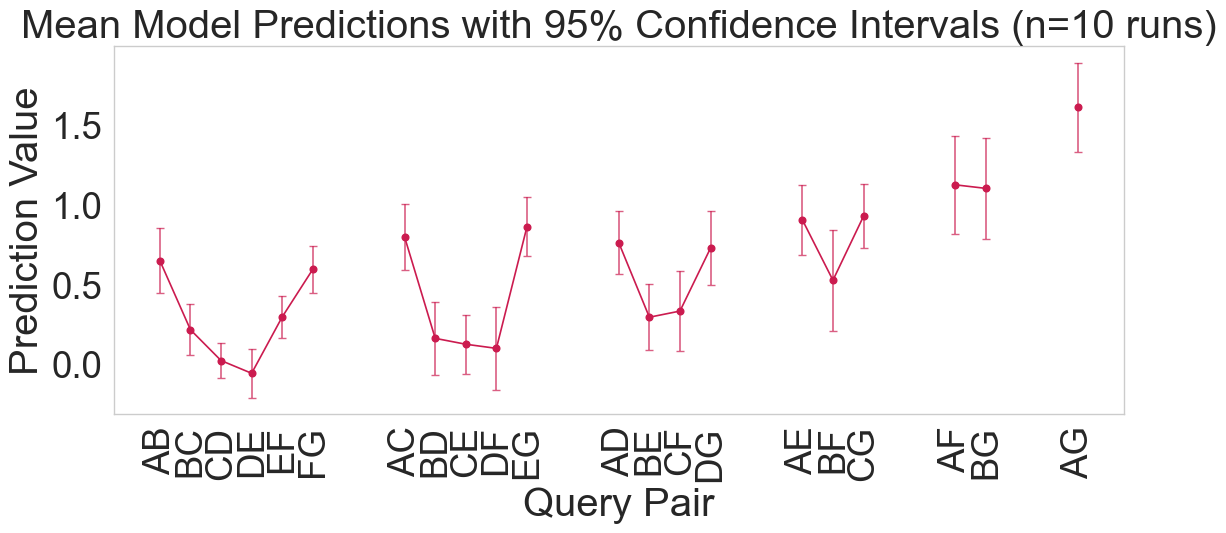

In [21]:
pred_mats = [pm.detach().numpy() for pm in pred_mats]
TI_per_pair_plot_with_confidence_intervals(pred_mats)

In [22]:
np.save('pred_mats_10runs_iwl.npy', np.array(pred_mats))